# Getting Started
In this post, we'll demonstrate some of the core functionality of the **SDMetrics** library by using it to evaluate a synthetic dataset.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Generating Synthetic Datasets
The **SDV** library provides tools for generating synthetic relational databases. Let's start by loading the Walmart dataset and generating a synthetic copy with 20 rows in the root table.

In [2]:
from sdv import load_demo

metadata, real_tables = load_demo("walmart", metadata=True)
for table_name, df in real_tables.items():
    print(">", table_name)
    print(df.head().to_string(index=False))
    print()

2020-06-25 19:46:08,024 - INFO - demo - Downloading dataset walmart from https://sdv-datasets.s3.amazonaws.com/walmart.zip
2020-06-25 19:46:16,109 - INFO - demo - Extracting dataset into /home/xals/.virtualenvs/SDMetrics/lib/python3.6/site-packages/sdv/data
2020-06-25 19:46:16,206 - INFO - metadata - Loading table stores
2020-06-25 19:46:16,213 - INFO - metadata - Loading table features
2020-06-25 19:46:16,227 - INFO - metadata - Loading table depts


> stores
 Store Type    Size
     1    A  151315
     2    A  202307
     3    B   37392
     4    A  205863
     5    B   34875

> features
 Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday
     1 2010-02-05        42.31       2.572        NaN        NaN        NaN        NaN        NaN  211.096358         8.106      False
     1 2010-02-12        38.51       2.548        NaN        NaN        NaN        NaN        NaN  211.242170         8.106       True
     1 2010-02-19        39.93       2.514        NaN        NaN        NaN        NaN        NaN  211.289143         8.106      False
     1 2010-02-26        46.63       2.561        NaN        NaN        NaN        NaN        NaN  211.319643         8.106      False
     1 2010-03-05        46.50       2.625        NaN        NaN        NaN        NaN        NaN  211.350143         8.106      False

> depts
 Store  Dept       Date  Weekly_Sales  I

In [3]:
from sdv import SDV

sdv = SDV()
sdv.fit(metadata, real_tables)

synthetic_tables = sdv.sample_all(100)
for table_name, df in synthetic_tables.items():
    print(">", table_name)
    print(df.head().to_string(index=False))
    print()

2020-06-25 19:46:16,573 - INFO - modeler - Modeling stores
2020-06-25 19:46:16,574 - INFO - metadata - Loading transformer CategoricalTransformer for field Type
2020-06-25 19:46:16,574 - INFO - metadata - Loading transformer NumericalTransformer for field Size
2020-06-25 19:46:16,583 - INFO - modeler - Modeling depts
2020-06-25 19:46:16,584 - INFO - metadata - Loading transformer DatetimeTransformer for field Date
2020-06-25 19:46:16,584 - INFO - metadata - Loading transformer NumericalTransformer for field Weekly_Sales
2020-06-25 19:46:16,585 - INFO - metadata - Loading transformer NumericalTransformer for field Dept
2020-06-25 19:46:16,585 - INFO - metadata - Loading transformer BooleanTransformer for field IsHoliday
2020-06-25 19:46:18,065 - INFO - modeler - Modeling features
2020-06-25 19:46:18,066 - INFO - metadata - Loading transformer DatetimeTransformer for field Date
2020-06-25 19:46:18,066 - INFO - metadata - Loading transformer NumericalTransformer for field MarkDown1
2020-0

> stores
Type    Size  Store
   B  162359      0
   A  170980      1
   A  121729      2
   A  119871      3
   B  105650      4

> depts
                         Date  Weekly_Sales  Store  Dept  IsHoliday
2012-02-09 21:17:12.955154432  36350.852015      0   103      False
2011-01-21 18:24:47.572623360  25216.388905      0    44      False
2010-06-18 12:19:42.539680512 -13136.641329      0    33      False
2012-01-24 22:12:11.601125120  18568.195813      0    66      False
2012-07-08 02:42:07.696383488   4870.694554      0    21      False

> features
                         Date     MarkDown1  Store  IsHoliday    MarkDown4     MarkDown3  Fuel_Price  Unemployment  Temperature  MarkDown5     MarkDown2         CPI
2012-05-18 06:23:23.519357440  13455.145775      0      False          NaN           NaN    3.331705      8.665745    38.100766        NaN           NaN  113.874949
2014-05-12 20:57:43.380266240           NaN      0      False          NaN           NaN    3.457125      7.9868

## Evaluation with SDMetrics
Now that we have (1) a metadata object, (2) a set of real tables, and (3) a set of fake tables, we can pass them to **SDMetrics** for evaluation. The simplest way to get started with **SDMetrics** is to use the `evaluate` function which generates a report with the default metrics.

In [4]:
from sdmetrics import evaluate
report = evaluate(metadata, real_tables, synthetic_tables)
report

The metrics report can provide an **overall score**. This is a single scalar value which you can pass to an optimization routine (i.e. to tune some hyperparameters in your model).

In [5]:
print(report.overall())

-60.23613058409412


Furthermore, the metrics report can also provide some key highlights. This shows the problem areas where your model performs especially poorly - for example, the below highlights suggest that our model is very bad at modeling the `MarkDownX` columns since the kstest has detected that the distributions look quite different between the real and synthetic versions.

In [6]:
report.highlights()

,Columns,Goal,Misc. Tags,Name,Tables,Unit,Value
0,column:MarkDown1,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,3.631931e-23
1,column:MarkDown4,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,4.654995e-59
2,column:MarkDown3,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,1.652154e-236
3,column:Fuel_Price,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,1.103714e-77
4,column:Unemployment,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,1.536199e-47
5,column:Temperature,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,1.435159e-08
6,column:MarkDown5,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,1.830072e-14
7,column:MarkDown2,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,2.546443e-227
8,column:CPI,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:features,p-value,0.000000e+00
9,column:Weekly_Sales,Goal.MAXIMIZE,"priority:high,statistic:univariate",kstest,table:depts,p-value,0.000000e+00


In addition, you will also be able to generate a visualization of the metrics.

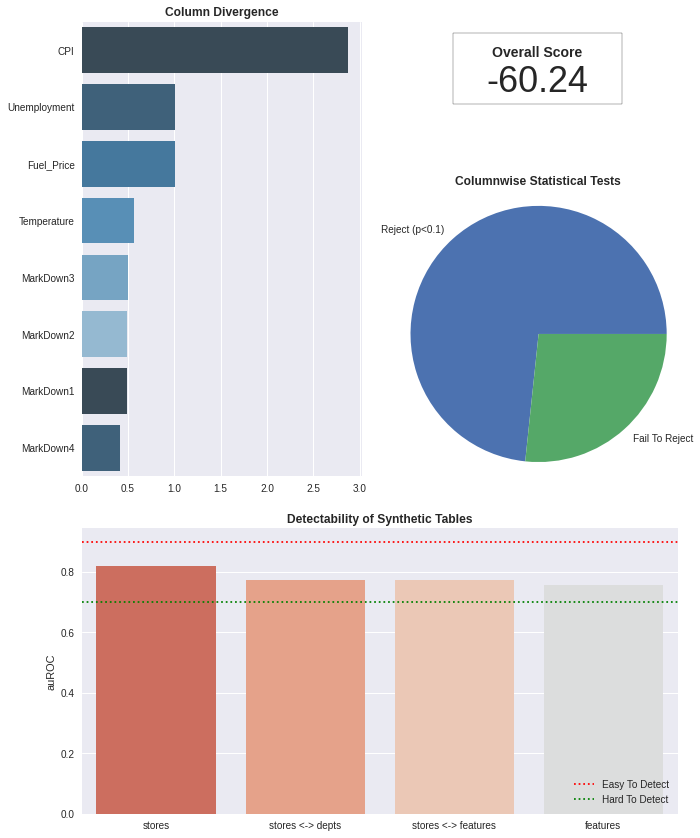

In [7]:
%matplotlib inline
report.visualize().savefig("../resources/visualize.png");

Finally, you can also print a detailed report containing all of the metrics that were computed.

In [8]:
report.details()

,Columns,Goal,Misc. Tags,Name,Tables,Unit,Value
0,,Goal.MAXIMIZE,child:depts,foreign-key,table:stores,binary,1.000000e+00
1,,Goal.MAXIMIZE,child:features,foreign-key,table:stores,binary,1.000000e+00
2,,Goal.MINIMIZE,detection:auroc,logistic,table:stores,auroc,7.595563e-01
3,,Goal.MINIMIZE,detection:auroc,logistic,table:features,auroc,7.583616e-01
4,,Goal.MINIMIZE,detection:auroc,logistic,table:depts,auroc,7.695387e-01
5,,Goal.MINIMIZE,detection:auroc,logistic,"table:stores,table:depts",auroc,7.749326e-01
6,,Goal.MINIMIZE,detection:auroc,logistic,"table:stores,table:features",auroc,7.721373e-01
7,column:Type,Goal.MAXIMIZE,statistic:univariate,chisquare,table:stores,p-value,9.703606e-01
8,column:IsHoliday,Goal.MAXIMIZE,statistic:univariate,chisquare,table:features,p-value,9.106489e-01
9,column:IsHoliday,Goal.MAXIMIZE,statistic:univariate,chisquare,table:depts,p-value,9.654409e-01
